<a href="https://colab.research.google.com/github/sdw1621/heseo_thesis/blob/main/%EB%84%A4%EC%9D%B4%EB%B2%84_%EC%87%BC%ED%95%91_%EB%A6%AC%EB%B7%B0_%EA%B0%90%EC%84%B1_%EB%B6%84%EB%A5%98%ED%95%98%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://wikidocs.net/94600

<h1> 네이버 쇼핑 리뷰 데이터 </h1>

---

1. 총 **20만개 리뷰**로 구성된 데이터

2. **평점이 5점 만점**에 **1, 2, 4, 5인 리뷰**들로 구성

  cf) **3점 리뷰**는 **긍부정 유무가 애매**하기 때문에 데이터 구성 시 **제외**

4. **평점 4, 5인 리뷰**들에 긍정을 의미하는 **레이블 1** 부여

   **평점 1, 2인 리뷰**들에 부정을 의미하는 **레이블 0** 부여

5. **감성 분류 모델 구축**

---


### 1. Colab에 Mecab 설치
<br>

**Mecab 이란?**

https://velog.io/@kjyggg/%ED%98%95%ED%83%9C%EC%86%8C-%EB%B6%84%EC%84%9D%EA%B8%B0-Mecab-%EC%82%AC%EC%9A%A9%ED%95%98%EA%B8%B0-A-to-Z%EC%84%A4%EC%B9%98%EB%B6%80%ED%84%B0-%EB%8B%A8%EC%96%B4-%EC%9A%B0%EC%84%A0%EC%88%9C%EC%9C%84-%EB%93%B1%EB%A1%9D%EA%B9%8C%EC%A7%80

**Colab에 형태소 분석기 Mecab을 설치**

In [ ]:
# Colab에 Mecab 설치
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 72, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (67/67), done.
remote: Total 72 (delta 31), reused 20 (delta 5), pack-reused 0
Unpacking objects: 100% (72/72), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
     |████████████████████████████████| 19.4MB 1.2MB/s 
     |████████████████████████████████| 460kB 54.0MB/s 
     |████████████████████████████████| 92kB 7.7MB/s 
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2020-12-02 08:05:12--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz


<h3> 2. 네이버 쇼핑 리뷰 데이터에 대한 이해와 전처리</h3>

[범용 감성 분석 참고 사이트]

https://bab2min.tistory.com/657






In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

<h3> 1) 데이터 로드하기 </h3>


[네이버 쇼핑 리뷰 원본 데이터 경로]

https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt

**naver_shopping.txt 다운로드**

In [ ]:
# 내 구글 드라이브로 연동하는 코드 넣기~!!

urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="ratings_total.txt")

('ratings_total.txt', <http.client.HTTPMessage at 0x7f2e2fad4be0>)

**naver_shopping.txt**

1. 열 제목 없음 => 임의로 'ratings'와 'reviews'를 추가
2. ratings_total.txt 파일로 저장



In [ ]:
total_data = pd.read_table('ratings_total.txt', names=['ratings', 'reviews'])

# 전체 리뷰 개수 출력
print('전체 리뷰 개수 :',len(total_data)) 

전체 리뷰 개수 : 200000


**전체 리뷰 개수 20만개 중 상위 5개만 출력**

In [ ]:
total_data[:5]

,ratings,reviews
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ


### 2) 훈련 데이터와 테스트 데이터 분리하기

**현 데이터는 레이블을 별도로 가지고 있지 않음**

**평점 1, 2인 리뷰**들에 부정을 의미하는 **레이블 0** 부여

**평점 4, 5인 리뷰**들에 긍정을 의미하는 **레이블 1** 부여

**부여된 레이블은 새로 생성한 label 열 저장**

In [ ]:
total_data['label'] = np.select([total_data.ratings > 3], [1], default=0)
total_data[:5]

NameError: ignored

**각 열(ratings, reviews, label)마다 중복 제외 샘플수 카운트**

In [ ]:
total_data['ratings'].nunique(), total_data['reviews'].nunique(), total_data['label'].nunique()

NameError: ignored

**ratings 열** : 1, 2, 4, 5 네 가지 데이터를 가짐

**reviews 열** : 중복 제외 199,908개의 리뷰 데이터를 가짐

cf) 전체가 20만개의 데이터이므로 리뷰가 중복인 데이터가 있다는 의미

**중복 데이터 제거**

In [ ]:
# reviews 열, 중복 데이터 제거
total_data.drop_duplicates(subset=['reviews'], inplace=True) 
print('총 샘플의 수 :',len(total_data))

**NULL 데이터 유무 확인**

In [ ]:
print(total_data.isnull().values.any())

**훈련 데이터 : 3**

**테스트 데이터 : 1**

**비율로 분리**

In [ ]:
train_data, test_data = train_test_split(total_data, test_size = 0.25, random_state = 42)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

**훈련용 리뷰 : 약 14만 9,900개**

**테스트용 리뷰 : 약 4만 9,900개**

**분리**

### 3) 레이블 분포 확인

**훈련 데이터 레이블 분포 확인**

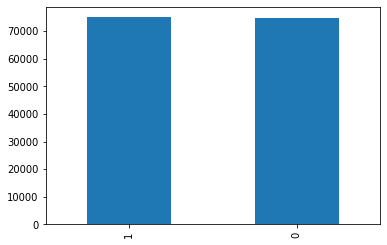

In [ ]:
train_data['label'].value_counts().plot(kind = 'bar')

In [ ]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  74918
1      1  75013


**두 레이블 모두 약 7만 5천개로 50:50 비율을 가짐**

### 4) 데이터 정제하기

**정규 표현식 사용 : 한글 제외 후 모두 제거**

정규 표현식 과정 중에 빈(Null) 데이터이 생기지는 않는지 확인합니다.

In [ ]:
# 한글과 공백을 제외하고 모두 제거
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['reviews'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

ratings    0
reviews    0
label      0
dtype: int64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:4581: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


테스트 데이터에 대해서도 같은 과정을 거칩니다.

In [ ]:
test_data.drop_duplicates(subset = ['reviews'], inplace=True) # 중복 제거
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


전처리 후 테스트용 샘플의 개수 : 49977


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:4581: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


### 5) 토큰화

형태소 분석기 Mecab을 사용하여 토큰화 작업을 수행합니다. 

다음은 임의의 문장에 대해서 테스트한 토큰화 결과입니다.

In [ ]:
mecab = Mecab()
print(mecab.morphs('와 이런 것도 상품이라고 차라리 내가 만드는 게 나을 뻔'))

['와', '이런', '것', '도', '상품', '이', '라고', '차라리', '내', '가', '만드', '는', '게', '나을', '뻔']


불용어를 지정하여 필요없는 토큰들은 제거하도록 합니다.

In [ ]:
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

훈련 데이터와 테스트 데이터에 대해서 동일한 과정을 거칩니다.

In [ ]:
train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

### 6) 단어와 길이 분포 확인하기

긍정 리뷰에는 주로 어떤 단어들이 많이 등장하고, 부정 리뷰에는 주로 어떤 단어들이 등장하는지 두 가지 경우에 대해서 각 단어의 빈도수를 계산해보겠습니다. 각 레이블에 따라서 별도로 단어들의 리스트를 저장해줍니다.

In [ ]:
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

Counter()를 사용하여 각 단어에 대한 빈도수를 카운트합니다. 우선 부정 리뷰에 대해서 빈도수가 높은 상위 20개 단어들을 출력합니다.

In [ ]:
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))

[('네요', 31799), ('는데', 20295), ('안', 19718), ('어요', 14849), ('있', 13200), ('너무', 13058), ('했', 11783), ('좋', 9812), ('배송', 9677), ('같', 8997), ('구매', 8876), ('어', 8869), ('거', 8854), ('없', 8670), ('아요', 8642), ('습니다', 8436), ('그냥', 8355), ('되', 8345), ('잘', 8029), ('않', 7984)]


In [ ]:
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

[('좋', 39488), ('아요', 21184), ('네요', 19895), ('어요', 18686), ('잘', 18602), ('구매', 16171), ('습니다', 13320), ('있', 12391), ('배송', 12275), ('는데', 11670), ('했', 9818), ('합니다', 9801), ('먹', 9635), ('재', 9273), ('너무', 8397), ('같', 7868), ('만족', 7261), ('거', 6482), ('어', 6294), ('쓰', 6292)]


좋', '아요', '네요', '잘', '너무', '만족' 등과 같은 단어들이 주로 많이 등장합니다. 두 가지 경우에 대해서 각각 길이 분포를 확인해봅시다.

긍정 리뷰의 평균 길이 : 13.587751456414221
부정 리뷰의 평균 길이 : 17.029512266744973


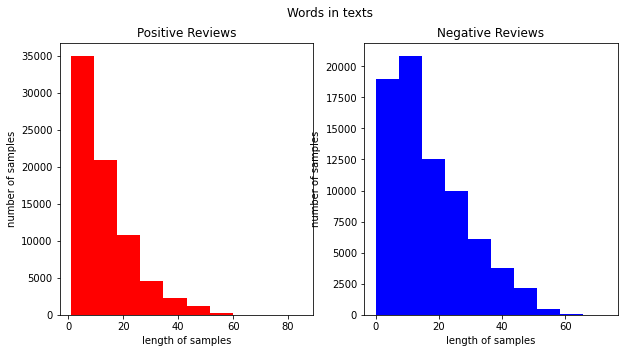

In [ ]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
text_len = train_data[train_data['label']==1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train_data[train_data['label']==0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()

긍정 리뷰보다는 부정 리뷰가 좀 더 길게 작성된 경향이 있는 것 같습니다.

In [ ]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

### 7) 정수 인코딩

이제 기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터에 정수 인코딩을 수행해야 합니다. 우선, 훈련 데이터에 대해서 단어 집합(vocaburary)을 만들어봅시다.

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여되었습니다. 이는 tokenizer.word_index를 출력하여 확인 가능합니다. 등장 횟수가 1회인 단어들은 자연어 처리에서 배제하고자 합니다. 이 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해봅시다.

In [ ]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 39998
등장 빈도가 1번 이하인 희귀 단어의 수: 18213
단어 집합에서 희귀 단어의 비율: 45.53477673883694
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.7935688376196857


단어가 약 40,000개가 존재합니다. 등장 빈도가 threshold 값인 2회 미만. 즉, 1회인 단어들은 단어 집합에서 약 45%를 차지합니다. 하지만, 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 매우 적은 수치인 약 0.8%밖에 되지 않습니다. 아무래도 등장 빈도가 1회인 단어들은 자연어 처리에서 별로 중요하지 않을 듯 합니다. 그래서 이 단어들은 정수 인코딩 과정에서 배제시키겠습니다.

등장 빈도수가 1인 단어들의 수를 제외한 단어의 개수를 단어 집합의 최대 크기로 제한하겠습니다.

In [ ]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 21787


이제 단어 집합의 크기는 21,787개입니다. 이를 토크나이저의 인자로 넘겨주면, 토크나이저는 텍스트 시퀀스를 숫자 시퀀스로 변환합니다. 이러한 정수 인코딩 과정에서 이보다 큰 숫자가 부여된 단어들은 OOV로 변환하겠습니다.

In [ ]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

정수 인코딩이 진행되었는지 확인하고자 X_train과 X_test에 대해서 상위 3개의 샘플만 출력합니다.

In [ ]:
print(X_train[:3])

[[67, 2060, 299, 14259, 263, 73, 6, 236, 168, 137, 805, 2951, 625, 2, 77, 62, 207, 40, 1343, 155, 3, 6], [482, 409, 52, 8530, 2561, 2517, 339, 2918, 250, 2357, 38, 473, 2], [46, 24, 825, 105, 35, 2372, 160, 7, 10, 8061, 4, 1319, 29, 140, 322, 41, 59, 160, 140, 7, 1916, 2, 113, 162, 1379, 323, 119, 136]]


In [ ]:
print(X_test[:3])

[[14, 704, 767, 116, 186, 252, 12], [339, 3904, 62, 3816, 1651], [11, 69, 2, 49, 164, 3, 27, 15, 6, 513, 289, 17, 92, 110, 564, 59, 7, 2]]


### 8) 패딩



이제 서로 다른 길이의 샘플들의 길이를 동일하게 맞춰주는 패딩 작업을 진행해보겠습니다. 전체 데이터에서 가장 길이가 긴 리뷰와 전체 데이터의 길이 분포를 알아보겠습니다.

리뷰의 최대 길이 : 85
리뷰의 평균 길이 : 15.307541469075774


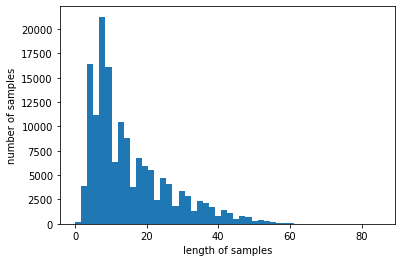

In [ ]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

리뷰의 최대 길이는 85, 평균 길이는 약 15입니다. 그리고 그래프로 봤을 때, 전체적으로는 60이하의 길이를 가지는 것으로 보입니다.

In [ ]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

최대 길이가 85이므로 만약 80으로 패딩할 경우, 몇 개의 샘플들을 온전히 보전할 수 있는지 확인해봅시다.

In [ ]:
max_len = 80
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 80 이하인 샘플의 비율: 99.99933302652553


훈련용 리뷰의 99.99%가 80이하의 길이를 가집니다. 훈련용 리뷰를 길이 80으로 패딩하겠습니다.

In [ ]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

## 3. GRU로 네이버 쇼핑 리뷰 감성 분류하기

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(GRU(128))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/15
1999/2000 [============================>.] - ETA: 0s - loss: 0.2738 - acc: 0.8972
Epoch 00001: val_acc improved from -inf to 0.91663, saving model to best_model.h5
2000/2000 [==============================] - 216s 108ms/step - loss: 0.2738 - acc: 0.8972 - val_loss: 0.2291 - val_acc: 0.9166
Epoch 2/15
1999/2000 [============================>.] - ETA: 0s - loss: 0.2143 - acc: 0.9229
Epoch 00002: val_acc improved from 0.91663 to 0.92467, saving model to best_model.h5
2000/2000 [==============================] - 222s 111ms/step - loss: 0.2143 - acc: 0.9229 - val_loss: 0.2076 - val_acc: 0.9247
Epoch 3/15
1999/2000 [============================>.] - ETA: 0s - loss: 0.1984 - acc: 0.9286
Epoch 00003: val_acc improved from 0.92467 to 0.92810, saving model to best_model.h5
2000/2000 [==============================] - 225s 112ms/step - loss: 0.1984 - acc: 0.9286 - val_loss: 0.2029 - val_acc: 0.9281
Epoch 4/15
2000/2000 [==============================] - ETA: 0s - loss: 0.1877 - acc: 0.

In [ ]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1562/1562 [==============================] - 28s 18ms/step - loss: 0.2093 - acc: 0.9246

 테스트 정확도: 0.9246


In [ ]:
def sentiment_predict(new_sentence):
  new_sentence = mecab.morphs(new_sentence) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

In [ ]:
sentiment_predict('이 상품 진짜 좋아요... 저는 강추합니다. 대박')

97.93% 확률로 긍정 리뷰입니다.


In [ ]:
sentiment_predict('진짜 배송도 늦고 개짜증나네요. 뭐 이런 걸 상품이라고 만듬?')

99.09% 확률로 부정 리뷰입니다.


In [ ]:
sentiment_predict('판매자님... 너무 짱이에요.. 대박나삼')

95.64% 확률로 긍정 리뷰입니다.


In [ ]:
sentiment_predict('ㅁㄴㅇㄻㄴㅇㄻㄴㅇ리뷰쓰기도 귀찮아')

87.69% 확률로 부정 리뷰입니다.
